In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

from inference import get_model
import supervision as sv

ROBOFLOW_API_KEY = 'tCy476DHnSoq6mwGtVpp'
PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

SOURCE_VIDEO_PATH = "../data/videos/old.mp4"

In [ ]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

Tracking test

In [ ]:
#Tracking IDs
BALL_ID = 0

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1 # remove ball class id
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

Split players into teams
- crop bboxes
- SigLIP - calculate embeddings
- UMAP - project embeddings 
- KMeans - two cluster division

In [ ]:
#use of the SigLIP, UMAP, and KMeans combo
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)
    
sv.plot_images_grid(crops[:20], grid_size=(2, 10))

Tracking with Team and GK association

In [ ]:
#GK Assignment - calculate avg centroid of players and assign GK to the team with the closest centroid

import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [ ]:
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

Pitch Keypoint Detection & Homography

In [ ]:
from inference import get_model

ROBOFLOW_API_KEY = 'tCy476DHnSoq6mwGtVpp'
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

import supervision as sv

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [ ]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

Keypoint 0: Frame Coordinates [        437         277], Pitch Coordinates [       6000           0]
Keypoint 1: Frame Coordinates [        450         407], Pitch Coordinates [       6000        2585]
Keypoint 2: Frame Coordinates [        463         569], Pitch Coordinates [       6000        4415]
Keypoint 3: Frame Coordinates [        517        1003], Pitch Coordinates [       6000        7000]
Keypoint 4: Frame Coordinates [       1473         305], Pitch Coordinates [       9985        1450]
Keypoint 5: Frame Coordinates [       1621         373], Pitch Coordinates [       9985        2584]
Keypoint 6: Frame Coordinates [       1838         478], Pitch Coordinates [       9985        4416]
Keypoint 7: Frame Coordinates [       1889         415], Pitch Coordinates [      10900        3500]
Keypoint 8: Frame Coordinates [       1910         353], Pitch Coordinates [      11450        2584]
Keypoint 9: Frame Coordinates [       1724         239], Pitch Coordinates [      12000    

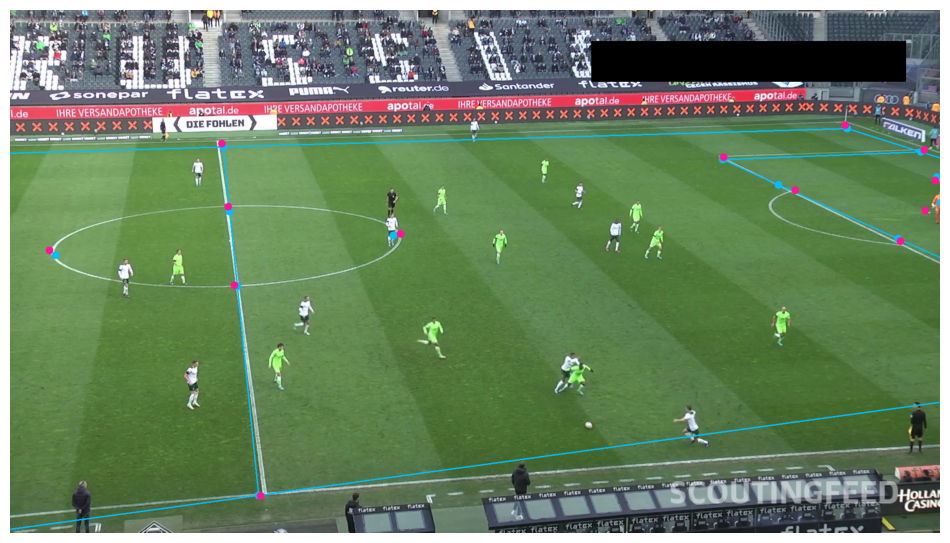

In [88]:
#project points and lines into the frame
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Print the mapping of frame keypoints to pitch keypoints
for i, (frame_point, pitch_point) in enumerate(zip(frame_reference_points, pitch_reference_points)):
    print(f"Keypoint {i}: Frame Coordinates {frame_point}, Pitch Coordinates {pitch_point}")

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

Everything working together + 2d view

In [ ]:
#For 1 Frame
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3


tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]

# team assignment
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections])

# frame visualization
labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and gk on pitch
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

# visualize video game-style radar view
annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

Collect Coords from every player, ball and gk per frame

In [ ]:
frames = []

for frame_index, frame in enumerate(sv.get_video_frames_generator(SOURCE_VIDEO_PATH)):
    if frame_index % 500 == 0:  # Save only every 5th frame
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

In [ ]:
pitch_frames = []
virt_frames = []

ball_coords = []
gk_t1_coords = []
gk_t2_coords = []

team_0_coords = []
team_1_coords = []

# Tracker
tracker = sv.ByteTrack()

for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")

    # ball, goalkeeper, player, referee detection
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    # Save ball coordinates
    if len(ball_detections.xyxy) > 0:
        x_min, y_min, x_max, y_max = ball_detections.xyxy[0]  # Assuming one ball per frame
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        ball_coords.append((frame_index, x_center, y_center))
    else:
        ball_coords.append((frame_index, None, None))  # No ball detected in this frame

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]

    # team assignment
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)
    
    # Save player coordinates per team (excluding goalkeepers)
    frame_team_0_coords = []
    frame_team_1_coords = []
    for player, team_id in zip(players_detections.xyxy, players_detections.class_id):
        x_min, y_min, x_max, y_max = player
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            frame_team_0_coords.append((x_center, y_center))  # Team 0 player coordinates
        elif team_id == 1:
            frame_team_1_coords.append((x_center, y_center))  # Team 1 player coordinates

    team_0_coords.append((frame_index, frame_team_0_coords))
    team_1_coords.append((frame_index, frame_team_1_coords))
    
    # Save goalkeeper coordinates for each team
    for gk, team_id in zip(goalkeepers_detections.xyxy, goalkeepers_detections.class_id):
        x_min, y_min, x_max, y_max = gk
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            gk_t1_coords.append((frame_index, x_center, y_center))
        elif team_id == 1:
            gk_t2_coords.append((frame_index, x_center, y_center))
    
    all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

    # frame visualization
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    pitch_frames.append(annotated_frame.copy())
    
    players_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections
    ])

    # detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    # project ball, players and gk on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)

    # visualize video game-style radar view
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)

    virt_frames.append(annotated_frame.copy())  
    
    if len(frames) < 50: #if low amount of frames, reset tracker
        tracker.reset() 

Frame 0


Processing...:   0%|          | 0/2 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.02s/it]


Frame 1


Processing...:  50%|█████     | 1/2 [00:07<00:07,  7.83s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.62s/it]
Processing...: 100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


Frame 0: Ball (1195.0, 857.5)
Frame 0: GK Team 1 Position: (1908.5, 264.0)
Frame 0: GK Team 2 Position: None
Frame 0: Team 0 Players: [(1011.0, 490.0), (556.0, 737.0), (1293.0, 427.5), (1329.5, 482.0), (874.5, 677.0), (1592.0, 652.5), (888.5, 392.5), (348.0, 532.0), (1104.0, 332.0), (1160.5, 751.5)]
Frame 0: Team 1 Players: [(609.0, 631.0), (387.5, 335.5), (1246.5, 466.0), (376.5, 773.5), (239.5, 553.5), (1174.5, 383.0), (1407.0, 859.5), (789.5, 453.0), (1911.0, 409.0), (960.0, 248.5)]


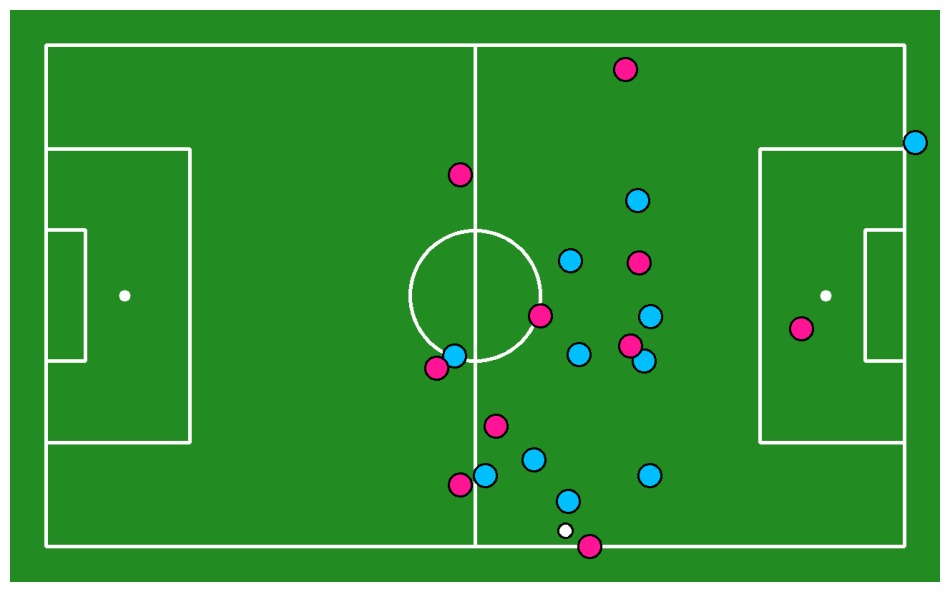

Frame 1: Ball (1829.5, 659.0)
Frame 1: GK Team 1 Position: (1835.0, 415.5)
Frame 1: GK Team 2 Position: None
Frame 1: Team 0 Players: [(1729.0, 641.0), (486.0, 678.0), (1148.5, 491.0), (1340.5, 713.0), (840.5, 599.0), (1371.5, 484.0), (959.0, 487.0), (859.0, 360.5), (230.5, 599.5), (611.0, 451.5)]
Frame 1: Team 1 Players: [(359.0, 699.0), (967.5, 558.0), (767.5, 591.0), (530.0, 474.0), (1069.0, 701.5), (638.0, 335.0), (1525.5, 629.5), (1251.0, 506.0), (201.5, 582.0), (239.5, 431.0)]


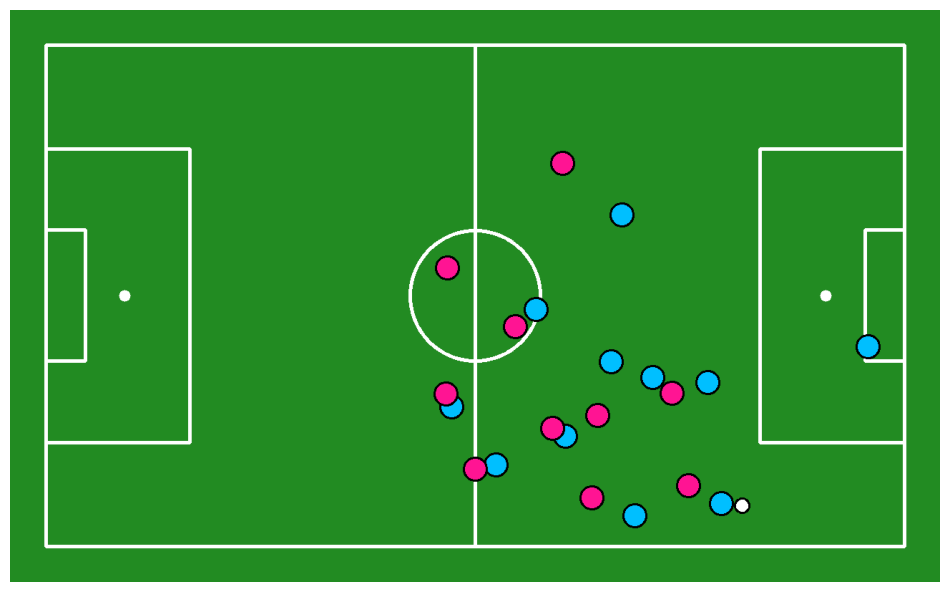

In [103]:
# Loop through ball positions, goalkeeper positions, and player coordinates per team
for (frame_index, ball_x, ball_y) in ball_coords:
    # Get the goalkeeper positions for the current frame
    gk_t1_pos = next((pos for pos in gk_t1_coords if pos[0] == frame_index), None)
    gk_t2_pos = next((pos for pos in gk_t2_coords if pos[0] == frame_index), None)

    # Get the player positions for the current frame
    team_0_players = next((coords for idx, coords in team_0_coords if idx == frame_index), [])
    team_1_players = next((coords for idx, coords in team_1_coords if idx == frame_index), [])

    # Print ball position
    print(f"Frame {frame_index}: Ball ({ball_x}, {ball_y})")

    # Print goalkeeper positions
    if gk_t1_pos:
        print(f"Frame {frame_index}: GK Team 1 Position: ({gk_t1_pos[1]}, {gk_t1_pos[2]})")
    else:
        print(f"Frame {frame_index}: GK Team 1 Position: None")

    if gk_t2_pos:
        print(f"Frame {frame_index}: GK Team 2 Position: ({gk_t2_pos[1]}, {gk_t2_pos[2]})")
    else:
        print(f"Frame {frame_index}: GK Team 2 Position: None")

    # Print player positions for Team 0
    print(f"Frame {frame_index}: Team 0 Players: {team_0_players}")

    # Print player positions for Team 1
    print(f"Frame {frame_index}: Team 1 Players: {team_1_players}")

    # Optionally visualize the frame
    sv.plot_image(virt_frames[frame_index])

Save ALL Coords in a CSV File

In [107]:
import csv

# Define the output file path
output_csv_path = "../data/raw/all_coordinates.csv"

# Save the data into a CSV file
with open(output_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(["frame_index", "ball_x", "ball_y", "gk_t1_x", "gk_t1_y", "gk_t2_x", "gk_t2_y", "team_0_players", "team_1_players"])
    
    # Write the data for each frame
    for frame_index, ball_x, ball_y in ball_coords:
        # Get goalkeeper positions
        gk_t1_pos = next((pos for pos in gk_t1_coords if pos[0] == frame_index), (None, None, None))
        gk_t2_pos = next((pos for pos in gk_t2_coords if pos[0] == frame_index), (None, None, None))
        
        # Get player positions
        team_0_players = next((coords for idx, coords in team_0_coords if idx == frame_index), [])
        team_1_players = next((coords for idx, coords in team_1_coords if idx == frame_index), [])
        
        # Write the row
        writer.writerow([
            frame_index,
            ball_x, ball_y,
            gk_t1_pos[1], gk_t1_pos[2],
            gk_t2_pos[1], gk_t2_pos[2],
            str(team_0_players),  # Convert list of tuples to string
            str(team_1_players)   # Convert list of tuples to string
        ])

print(f"Coordinates saved to {output_csv_path}")

Coordinates saved to ../data/raw/all_coordinates.csv
